In [1]:
# # comment when run locally
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive/My\ Drive/similar_faces/

In [2]:
# # uncomment when run locally
# !rm -rf /data_celeba
# !mkdir /data_celeba
# %cp celeba_identity.txt /data_celeba
# %cp img_align_celeba.zip /data_celeba
# %cd /data_celeba
# !unzip -q img_align_celeba.zip
# %ls

In [3]:
import os
import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
from torchvision.utils import make_grid
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from collections import defaultdict
%matplotlib inline

In [4]:
sns.set()
if torch.cuda.is_available():
    print(f'Cuda device: {torch.cuda.get_device_name(0)}')
else:
    print('Cuda unavailable')

Cuda unavailable


## Hyperparameters

In [5]:
num_epochs = 10
batch_size = 32
learning_rate = 0.0003

## Dataset

In [6]:
class SimilarFaceDataset(Dataset):
    def __init__(self, is_train=True):
        with open('celeba_identity.txt') as f:
            filename_identity = [x.split() for x in f.readlines()]
        identity_filenames_dict = defaultdict(list)
        for i in filename_identity:
            identity_filenames_dict[int(i[1])].append(i[0])
        self.identity_filenames_list = []
        for i in range(len(identity_filenames_dict)):
            tmp = []
            for filename in identity_filenames_dict[i+1]:
                tmp.append(filename)
            if len(tmp) >= 2:
                self.identity_filenames_list.append(tmp)
        
        if is_train:
            self.identity_filenames_list = self.identity_filenames_list[:9000]
        else:
            self.identity_filenames_list = self.identity_filenames_list[9000:]
            
        self.transform = transforms.ToTensor()
        
        self.anchor_count = 3
        self.positive_count = 3
        self.negative_identity_count = 3
        self.negative_count = 3
        # num_examples ~ 10177 * anchor_count * positive_count * negative_identity_count * negative_count
        
        self.triplet_indices = []
        for positive_identity_index in range(len(self.identity_filenames_list)):
            for anchor_index in random.sample(range(len(self.identity_filenames_list[positive_identity_index])), min(self.anchor_count, len(self.identity_filenames_list[positive_identity_index]))):
                for positive_index in random.sample(range(len(self.identity_filenames_list[positive_identity_index])), min(self.positive_count, len(self.identity_filenames_list[positive_identity_index]))):
                    if anchor_index != positive_index:
                        for negative_identity_index in random.sample(range(len(self.identity_filenames_list)), min(self.negative_identity_count, len(self.identity_filenames_list))):
                            if positive_identity_index != negative_identity_index:
                                for negative_index in random.sample(range(len(self.identity_filenames_list[negative_identity_index])), min(self.negative_count, len(self.identity_filenames_list[negative_identity_index]))):
                                    self.triplet_indices.append([positive_identity_index, negative_identity_index, anchor_index, positive_index, negative_index])
            
    def __len__(self):
        return len(self.triplet_indices)
    
    def __getitem__(self, index):
        """Return a tuple (Anchor, Positive, Negative)"""
        positive_identity_index, negative_identity_index, anchor_index, positive_index, negative_index = self.triplet_indices[index]
        anchor = Image.open(f'img_align_celeba/{self.identity_filenames_list[positive_identity_index][anchor_index]}')
        positive = Image.open(f'img_align_celeba/{self.identity_filenames_list[positive_identity_index][positive_index]}')
        negative = Image.open(f'img_align_celeba/{self.identity_filenames_list[negative_identity_index][negative_index]}')
        anchor = self.transform(anchor)
        positive = self.transform(positive)
        negative = self.transform(negative)
        return anchor, positive, negative

## Network

In [7]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            residual = self.downsample(residual)
            
        x += residual
        x = F.relu(x)
        
        return x
    
class ResNet(nn.Module):
    def __init__(self, block, layers, out_channels=10):
        super().__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], 2)
        self.layer3 = self._make_layer(block, 64, layers[2], 2)
        self.layer4 = self._make_layer(block, 128, layers[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, out_channels)
        
    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding_net = ResNet(ResidualBlock, [2, 2, 2, 2], out_channels=10)
        
    def get_embedding(self, x):
        return self.embedding_net(x)
        
    def forward(self, a, p, n):
        a_out = self.embedding_net(a)
        p_out = self.embedding_net(p)
        n_out = self.embedding_net(n)
        return (a_out, p_out, n_out)

## Preparation

In [8]:
train_dataset = SimilarFaceDataset(is_train=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = SimilarFaceDataset(is_train=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)

# Loss and optimizer
criterion = torch.nn.TripletMarginLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [10]:
# Load checkpoint
checkpoint = torch.load('checkpoint', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [11]:
model.train()

num_step_to_print_info = 10
train_avg_loss = 0
train_avg_loss_history = []

total_step = len(train_loader)
for epoch in range(num_epochs):
    for step, (anchors, positives, negatives) in enumerate(train_loader):
        anchors = anchors.to(device)
        positives = positives.to(device)
        negatives = negatives.to(device)
        
        # forward pass
        anchor_outputs, positive_outputs, negative_outputs = model(anchors, positives, negatives)
        loss = criterion(anchor_outputs, positive_outputs, negative_outputs)
        train_avg_loss += loss.item()
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (step + 1) % num_step_to_print_info == 0:
            model.eval()
            test_avg_loss = 0
            test_iter = iter(test_loader)
            for i in range(num_step_to_print_info):
                test_anchors, test_positives, test_negatives = test_iter.next()
                test_anchors = test_anchors.to(device)
                test_positives = test_positives.to(device)
                test_negatives = test_negatives.to(device)
                test_anchor_outputs, test_positive_outputs, test_negative_outputs = model(test_anchors, test_positives, test_negatives)
                loss = criterion(test_anchor_outputs, test_positive_outputs, test_negative_outputs)
                test_avg_loss += loss.item()
            
            train_avg_loss = train_avg_loss / num_step_to_print_info
            test_avg_loss = test_avg_loss / num_step_to_print_info
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{total_step}], Train avg loss: {train_avg_loss:.4f}, Test avg loss: {test_avg_loss:.4f}')
            train_avg_loss_history.append(train_avg_loss)
            train_avg_loss = 0
            
            model.train()
            torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict()
                        }, 'checkpoint')

plt.plot(accu_loss_history)

Epoch [1/10], Step [10/40992], Train avg loss: 0.0760, Test avg loss: 0.0024


KeyboardInterrupt: 

## Test on custom data

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 
Explained variance vatio: [0.33079982 0.30959523]


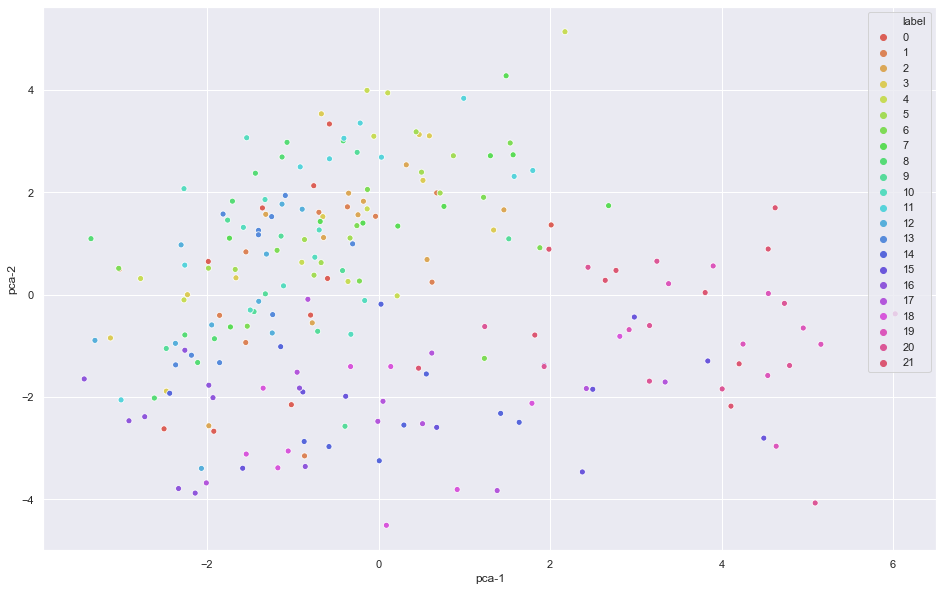

In [12]:
model.eval()
count = 22
transform = transforms.Compose([
    transforms.Resize((217, 178)),
    transforms.ToTensor(),
    lambda x: x[:3]
])

images = torch.empty(220, 3, 217, 178)
j = 0
for i in range(count):
    pathname = os.path.join('./data', f'c{i+1}')
    for filename in glob.glob(f'{pathname}/*'):
        images[j] = transform(Image.open(filename))
        j += 1
    print(f'{i} ', end='')

embeddings = model.get_embedding(images).detach().numpy()

pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)
df = pd.DataFrame()
df['pca-1'] = pca_result[:, 0]
df['pca-2'] = pca_result[:, 1]
df['label'] = [i for i in range(count) for j in range(10)]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='pca-1', 
    y='pca-2',
    hue='label',
    palette=sns.color_palette("hls", count),
    data=df
)
print(f'\nExplained variance vatio: {pca.explained_variance_ratio_}')

[ 0.        4.988889  8.082719  8.770152  9.223226 10.041762 10.460292
 10.555681 11.011195 11.379589]


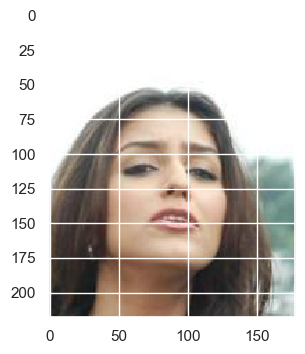

In [20]:
target_face_index = 200
k = 10
l2_distances = ((embeddings[target_face_index] - embeddings) ** 2).sum(axis=1)
closest_k_face_indices = np.argsort(l2_distances)[:k]
closest_k_faces = images[closest_k_face_indices]
print(l2_distances[closest_k_face_indices])

plt.figure(dpi=100)
plt.imshow(np.transpose(images[target_face_index], (1, 2, 0)))

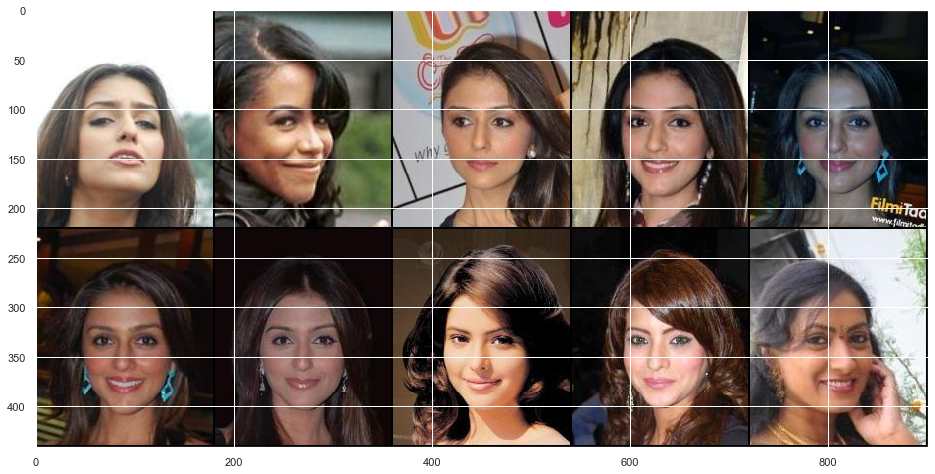

In [21]:
plt.figure(figsize=(16, 10))
plt.imshow(np.transpose(make_grid(closest_k_faces, 5), (1, 2, 0)))

## Test on celeba data


Explained variance vatio: [0.4626146  0.19592899]


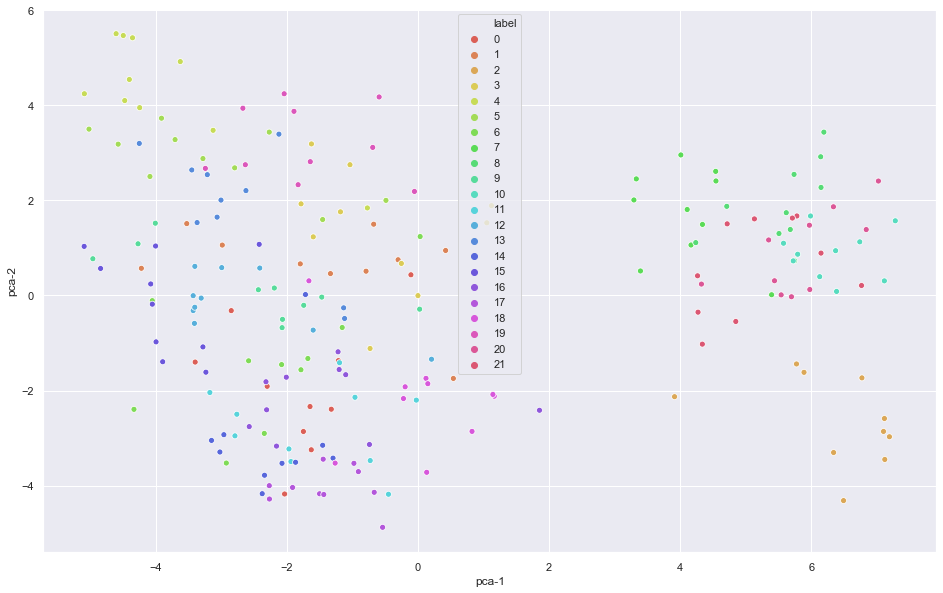

In [16]:
model.eval()
count = 22
with open('celeba_identity.txt') as f:
    filename_identity = [x.split() for x in f.readlines()]
    identity_filenames_dict = defaultdict(list)
    for i in filename_identity:
        identity_filenames_dict[int(i[1])].append(i[0])
    identity_filenames_list = []
    for i in range(len(identity_filenames_dict)):
        tmp = []
        for filename in identity_filenames_dict[i+1]:
            tmp.append(filename)
        if len(tmp) >= 10:
            identity_filenames_list.append(tmp[:10])
    mask = random.sample(range(len(identity_filenames_list)), count)
    identity_filenames_list_ = []
    for i in mask:
        identity_filenames_list_.append(identity_filenames_list[i])    
    transform = transforms.ToTensor()

images = []
for i in range(count):
    tmp = []
    for j in range(10):
        filename = identity_filenames_list[i][j]
        images.append(transform(Image.open(f'./img_align_celeba/{filename}')))
images = torch.stack(images)

embeddings = model.get_embedding(images)
embeddings = embeddings.detach().numpy()

pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)
df = pd.DataFrame()
df['pca-1'] = pca_result[:, 0]
df['pca-2'] = pca_result[:, 1]
df['label'] = [i for i in range(count) for j in range(10)]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='pca-1', 
    y='pca-2',
    hue='label',
    palette=sns.color_palette("hls", count),
    data=df
)
print(f'\nExplained variance vatio: {pca.explained_variance_ratio_}')

[0.        4.2053804 4.9566116]


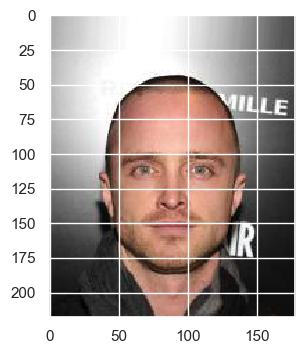

In [30]:
target_face_index = 144
k = 3
l2_distances = ((embeddings[target_face_index] - embeddings) ** 2).sum(axis=1)
closest_k_face_indices = np.argsort(l2_distances)[:k]
closest_k_faces = images[closest_k_face_indices]
print(l2_distances[closest_k_face_indices])

plt.figure(dpi=100)
plt.imshow(np.transpose(images[target_face_index], (1, 2, 0)))

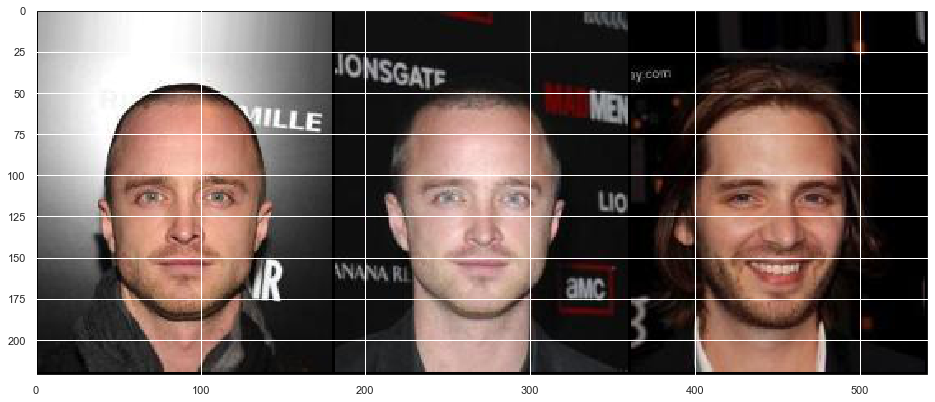

In [31]:
plt.figure(figsize=(16, 10))
plt.imshow(np.transpose(make_grid(closest_k_faces, 5), (1, 2, 0)))